In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast


In [61]:
def boxplots(resfile):
    df = pd.read_csv(resfile)
    # column_mapper = dict(zip(["SN GN","CN GN","SN TN","CN TN","SN HIV+","CN HIV+"],["social->genetic","contact->genetic","social->transmission","contact->transmission""social HIV+","contact HIV+"]))
    df.boxplot(column=["SN GN count","CN GN count","SN TN count","CN TN count"],positions=[1,2,3,4],patch_artist=True,medianprops=dict(color="k"),notch=True)

    # df.boxplot(column=["SN GN count","SN TN count"],positions=[1,3],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN GN count","CN TN count"],return_type="dict",positions=[2,4],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.ylim([0,11])
    plt.show()

    df.boxplot(column=["SN HIV+","CN HIV+"],positions=[1,2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # df.boxplot(column=["SN HIV+"],positions=[1],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN HIV+"],return_type="dict",positions=[2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.ylim([0,300])
    plt.show()

    df["SN sample size"] = [len(ast.literal_eval(x)) for x in df["SN sampled"]] #df.apply(lambda x: x["SN sampled"].len())
    df["CN sample size"] = [len(ast.literal_eval(x)) for x in df["CN sampled"]] #df.apply(lambda x: x["CN sampled"].len())

    df.boxplot(column=["SN sample size","CN sample size"],positions=[1,2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # df.boxplot(column=["SN sample size"],positions=[1],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN sample size"],return_type="dict",positions=[2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.ylim([0,625])
    plt.show()


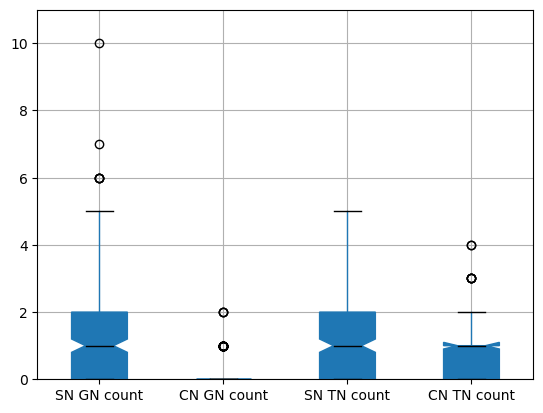

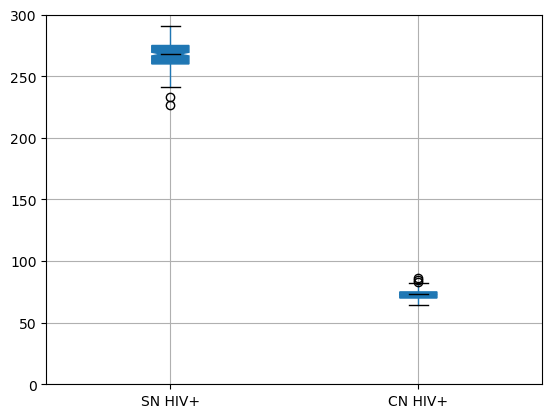

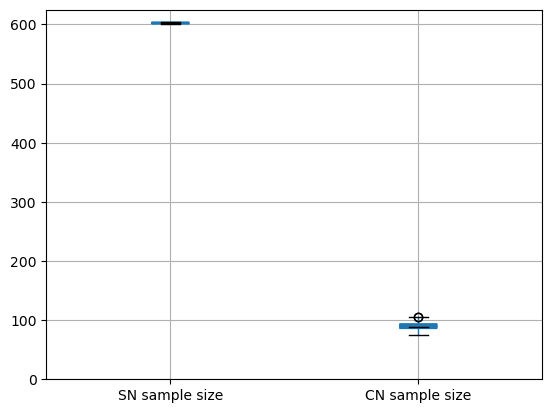

In [62]:
# stats_df = make_stats_df("all_summaries_20221017.csv")
# visualize(stats_df)
boxplots("all_summaries_20221017.csv")